# **UTMobileNet2021 Veriseti Ön İşleme** 


## Kurulumlar

In [15]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/UTMobileNet2021_analiz/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/UTMobileNet2021_analiz


In [18]:
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sbn
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras

### Yapılanlar

1. UDP sayısının az olması ve eksik verilerden dolayı yalnızca TCP kullanılmıştır. UDP kullanan kayıtlar çıkarılmıştır. Aynı zamanda UDP başlık bilgisi öznitelikleri `udp.srcport`,`udp.dstport`,`udp.length`,`udp.checksum`,`gquic.puflags.rsv`,`gquic.packet_number` çıkarılmıştır.

2. Gereksiz verilerçıkarıldı.

>'frame.time','Unnamed: 0','frame.number' 


3. SimpleImputer ile boş değerler dolduruldu.

*   tcp.option_kind, tcp.option_len, "most_frequent"


*   tcp.options.timestamp.tsval,tcp.options.timestamp.tsecr -----> "median"


4. Label Encooding yapıldı. 

> `sll.src.etc`,`sll.unused`,`ip.id`,`ip.checksum`,`ip.src`,`ip.dst`,`tcp.checksum`,`tcp.option_kind`, `tcp.option_kind`, `application`


5. Tüm örnekler için aynı değere sahip olan öznitelikler çıkarıldı. `sll.etype`, `sll.halen`, `'ip.hdr_len'`, `'ip.dsfield.ecn'`, `'ip.frag_offset'`, `'ip.proto'`, `'tcp.flags.ns'`, `'tcp.urgent_pointer'`



In [19]:
dataset = pd.read_csv("UTMobileNet2021.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (11,12,13,15,16,17,33,39,40) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [20]:
dataset.tail(5)

,Unnamed: 0,frame.number,frame.time,frame.len,frame.cap_len,sll.pkttype,sll.hatype,sll.halen,sll.src.eth,sll.unused,...,tcp.option_len,tcp.options.timestamp.tsval,tcp.options.timestamp.tsecr,udp.srcport,udp.dstport,udp.length,udp.checksum,gquic.puflags.rsv,gquic.packet_number,application
686060,686060,24291,"Mar 31, 2019 22:04:18.765964000 CDT",64,64,0,1,6,00:6c:bc:1c:5f:07,9f:a7,...,NaN,NaN,NaN,443.0,57579.0,28.0,0x00009c4c,0x00000000,6.0,Youtube
686061,686061,24292,"Mar 31, 2019 22:04:18.766503000 CDT",72,72,4,1,6,fc:c2:de:bc:a6:23,6e:22,...,NaN,NaN,NaN,57579.0,443.0,36.0,0x0000321c,0x00000000,7.0,Youtube
686062,686062,24293,"Mar 31, 2019 22:04:19.653748000 CDT",91,91,4,1,6,fc:c2:de:bc:a6:23,00:00,...,10.0,550093.0,3.873080e+09,NaN,NaN,NaN,NaN,NaN,NaN,Youtube
686063,686063,24294,"Mar 31, 2019 22:04:19.677267000 CDT",56,56,0,1,6,00:6c:bc:1c:5f:07,0a:94,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Youtube
686064,686064,24295,"Mar 31, 2019 22:04:19.865410000 CDT",169,169,4,1,6,fc:c2:de:bc:a6:23,53:16,...,NaN,NaN,NaN,45117.0,1900.0,133.0,0x0000296e,NaN,NaN,Youtube


In [21]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 686065 entries, 0 to 686064
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   686065 non-null  int64  
 1   frame.number                 686065 non-null  int64  
 2   frame.time                   686065 non-null  object 
 3   frame.len                    686065 non-null  int64  
 4   frame.cap_len                686065 non-null  int64  
 5   sll.pkttype                  686065 non-null  int64  
 6   sll.hatype                   686065 non-null  int64  
 7   sll.halen                    686065 non-null  int64  
 8   sll.src.eth                  686065 non-null  object 
 9   sll.unused                   686065 non-null  object 
 10  sll.etype                    686060 non-null  object 
 11  ip.hdr_len                   685784 non-null  object 
 12  ip.dsfield.ecn               685784 non-null  object 
 13 

In [22]:
dataset= dataset.dropna(subset=["tcp.hdr_len"])

In [23]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 634958 entries, 0 to 686063
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   634958 non-null  int64  
 1   frame.number                 634958 non-null  int64  
 2   frame.time                   634958 non-null  object 
 3   frame.len                    634958 non-null  int64  
 4   frame.cap_len                634958 non-null  int64  
 5   sll.pkttype                  634958 non-null  int64  
 6   sll.hatype                   634958 non-null  int64  
 7   sll.halen                    634958 non-null  int64  
 8   sll.src.eth                  634958 non-null  object 
 9   sll.unused                   634958 non-null  object 
 10  sll.etype                    634958 non-null  object 
 11  ip.hdr_len                   634958 non-null  object 
 12  ip.dsfield.ecn               634958 non-null  object 
 13 

In [24]:
dataset= dataset.drop(columns= ['udp.srcport', 'udp.dstport', 'udp.length', 'udp.checksum', 'gquic.puflags.rsv', 
                                'gquic.packet_number','frame.time','Unnamed: 0','frame.number'])

In [25]:
dataset['sll.etype'].value_counts()

0x00000800    634958
Name: sll.etype, dtype: int64

In [26]:
dataset= dataset.drop(columns= ['sll.etype'])

In [27]:
dataset['sll.src.eth'].value_counts()

00:6c:bc:1c:5f:b9    391495
fc:c2:de:70:08:b1    161142
00:6c:bc:1c:5f:07     54062
00:00:00:00:00:00     14412
fc:c2:de:bc:a6:23     13847
Name: sll.src.eth, dtype: int64

In [28]:
from sklearn.preprocessing import LabelEncoder
dataset["sll.src.eth"]= LabelEncoder().fit_transform(dataset['sll.src.eth'])

In [29]:
dataset['sll.unused'].value_counts()

00:00    45956
08:00     7246
00:6c     3771
64:00     3356
00:06     2766
         ...  
a6:9b        1
b1:df        1
85:b4        1
02:aa        1
de:75        1
Name: sll.unused, Length: 65518, dtype: int64

In [30]:
from sklearn.preprocessing import LabelEncoder
dataset['sll.unused']= LabelEncoder().fit_transform(dataset['sll.unused'])

In [31]:
dataset['ip.id'].value_counts()

0x00000000    4275
0x00000001    2338
0x00000002    1875
0x00000003    1795
0x00000004    1686
              ... 
0x00005178       2
0x00005179       2
0x0000517a       2
0x0000517b       2
0x00005185       2
Name: ip.id, Length: 65536, dtype: int64

In [32]:
from sklearn.preprocessing import LabelEncoder
dataset['ip.id']= LabelEncoder().fit_transform(dataset['ip.id'])

In [33]:
dataset['ip.checksum'].value_counts()

0x00002069    2886
0x00002068    2188
0x00002067    1733
0x00002066    1660
0x00002065    1576
              ... 
0x0000ad8e       2
0x0000a0e5       2
0x0000a0ab       2
0x0000a27d       2
0x0000a7f2       2
Name: ip.checksum, Length: 65535, dtype: int64

In [34]:
from sklearn.preprocessing import LabelEncoder
dataset['ip.checksum']= LabelEncoder().fit_transform(dataset['ip.checksum'])

In [35]:
dataset['ip.src'].value_counts()

10.145.102.237    161142
216.58.194.74      68195
172.217.14.170     53293
152.195.33.40      48652
192.124.233.66     45593
                   ...  
192.124.233.10         5
104.244.42.194         5
104.244.42.6           4
104.154.127.47         4
54.186.169.114         4
Name: ip.src, Length: 172, dtype: int64

In [36]:
from sklearn.preprocessing import LabelEncoder
dataset['ip.src']= LabelEncoder().fit_transform(dataset['ip.src'])

In [37]:
dataset['ip.dst'].value_counts()

10.145.102.237    391495
216.58.194.74      63703
10.148.245.180     54062
151.101.50.18      14922
127.0.0.1          14412
                   ...  
54.186.169.114         6
192.124.233.10         5
69.195.183.128         3
69.195.173.128         3
69.195.161.128         3
Name: ip.dst, Length: 177, dtype: int64

In [38]:
from sklearn.preprocessing import LabelEncoder
dataset['ip.dst']= LabelEncoder().fit_transform(dataset['ip.dst'])

In [39]:
dataset['tcp.checksum'].value_counts()

0x00003b38    11058
0x00002d28     8851
0x0000b998     6157
0x00000c2a     5903
0x00000f03     5565
              ...  
0x0000136a        1
0x0000859f        1
0x0000d170        1
0x00006e08        1
0x00005c90        1
Name: tcp.checksum, Length: 65519, dtype: int64

In [40]:
from sklearn.preprocessing import LabelEncoder
dataset['tcp.checksum']= LabelEncoder().fit_transform(dataset['tcp.checksum'])

In [41]:
dataset['tcp.option_kind'].value_counts()

1,1,8          547100
1,1,8,1,1,5     19435
1,1,5            3281
2,4,8,1,3        1456
2,1,3,4,8          27
2                   7
2,1,1,4,1,3         4
2,1,1,8,4,0         2
Name: tcp.option_kind, dtype: int64

In [42]:
from sklearn.impute import SimpleImputer

imputer= SimpleImputer(missing_values=np.NaN, strategy="most_frequent")
dataset['tcp.option_kind']=imputer.fit_transform(dataset['tcp.option_kind'].values.reshape(-1,1))

In [43]:
from sklearn.preprocessing import LabelEncoder
dataset['tcp.option_kind']= LabelEncoder().fit_transform(dataset['tcp.option_kind'])

In [44]:
dataset['tcp.option_len'].value_counts()

10          498449
10           49152
10,26        16913
34            2627
10,10         1852
4,2,10,3      1456
10,18          670
18             104
4,3,2,10        27
26              26
10.0            23
4                7
4,2,3            4
4,10,2           2
Name: tcp.option_len, dtype: int64

In [45]:
dataset['tcp.option_len']=  dataset['tcp.option_len'].replace(10,"10")
dataset['tcp.option_len']=  dataset['tcp.option_len'].replace("10.0","10")

In [46]:
from sklearn.impute import SimpleImputer
imputer= SimpleImputer(missing_values=np.NaN, strategy="most_frequent")
dataset['tcp.option_len']=imputer.fit_transform(dataset['tcp.option_len'].values.reshape(-1,1))

In [47]:
from sklearn.preprocessing import LabelEncoder
dataset['tcp.option_len']= LabelEncoder().fit_transform(dataset['tcp.option_len'])

In [48]:
dataset["ip.hdr_len"]= dataset["ip.hdr_len"].astype(float)
dataset["ip.len"]= dataset["ip.len"].astype(float)
dataset['ip.dsfield.ecn']= dataset['ip.dsfield.ecn'].astype(float)
dataset['ip.frag_offset']= dataset['ip.frag_offset'].astype(float)
dataset['ip.ttl']= dataset['ip.ttl'].astype(float)
dataset['ip.proto']= dataset['ip.proto'].astype(float)

In [49]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 634958 entries, 0 to 686063
Data columns (total 33 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   frame.len                    634958 non-null  int64  
 1   frame.cap_len                634958 non-null  int64  
 2   sll.pkttype                  634958 non-null  int64  
 3   sll.hatype                   634958 non-null  int64  
 4   sll.halen                    634958 non-null  int64  
 5   sll.src.eth                  634958 non-null  int64  
 6   sll.unused                   634958 non-null  int64  
 7   ip.hdr_len                   634958 non-null  float64
 8   ip.dsfield.ecn               634958 non-null  float64
 9   ip.len                       634958 non-null  float64
 10  ip.id                        634958 non-null  int64  
 11  ip.frag_offset               634958 non-null  float64
 12  ip.ttl                       634958 non-null  float64
 13 

In [50]:
from sklearn.impute import SimpleImputer
imputer= SimpleImputer(missing_values=np.NaN, strategy="median")
dataset['tcp.options.timestamp.tsval']=imputer.fit_transform(dataset['tcp.options.timestamp.tsval'].values.reshape(-1,1))

In [51]:
from sklearn.impute import SimpleImputer
imputer= SimpleImputer(missing_values=np.NaN, strategy="median")
dataset['tcp.options.timestamp.tsecr']=imputer.fit_transform(dataset['tcp.options.timestamp.tsecr'].values.reshape(-1,1))

In [52]:
dataset.application.value_counts()

Google Drive    218098
Hulu             85044
Pinterest        59167
Netflix          58684
Instagram        46207
Google Maps      41919
Reddit           39493
Spotify          33726
Twitter          23672
Facebook         21004
Gmail             4338
Hangouts          1927
Messenger         1288
Youtube            391
Name: application, dtype: int64

Text(0.5, 1.0, 'Numbers of Applications ')

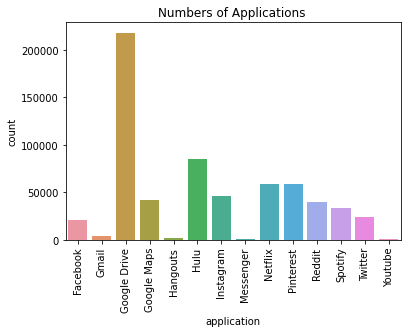

In [53]:
sbn.countplot(x="application", data = dataset)
plt.xticks(rotation = 'vertical')
plt.title(label="Numbers of Applications ")

In [54]:
from sklearn.preprocessing import LabelEncoder
dataset['application']= LabelEncoder().fit_transform(dataset['application'])

In [55]:
dataset.application.value_counts()

2     218098
5      85044
9      59167
8      58684
6      46207
3      41919
10     39493
11     33726
12     23672
0      21004
1       4338
4       1927
7       1288
13       391
Name: application, dtype: int64

In [56]:
dataset.describe()

,frame.len,frame.cap_len,sll.pkttype,sll.hatype,sll.halen,sll.src.eth,sll.unused,ip.hdr_len,ip.dsfield.ecn,ip.len,...,tcp.flags.ns,tcp.flags.fin,tcp.window_size_value,tcp.checksum,tcp.urgent_pointer,tcp.option_kind,tcp.option_len,tcp.options.timestamp.tsval,tcp.options.timestamp.tsecr,application
count,634958.000000,634958.000000,634958.000000,634958.000000,634958.0,634958.000000,634958.000000,634958.0,634958.0,634958.000000,...,634958.0,634958.000000,634958.000000,634958.000000,634958.0,634958.000000,634958.000000,6.349580e+05,6.349580e+05,634958.000000
mean,1172.726461,168.062873,1.102366,18.499822,6.0,2.166861,29479.240723,20.0,0.0,1156.723736,...,0.0,0.001452,1198.228593,30432.787093,0.0,1.039466,0.131891,1.777548e+09,5.045483e+08,5.264151
std,1579.174015,335.771274,1.787249,114.830918,0.0,0.699361,20393.341103,0.0,0.0,1579.175936,...,0.0,0.038078,3425.051873,19323.927020,0.0,0.343486,0.757834,1.422602e+09,9.712105e+08,3.458597
min,56.000000,56.000000,0.000000,1.000000,6.0,0.000000,0.000000,20.0,0.0,40.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,2.994530e+05,0.000000e+00,0.000000
25%,1306.000000,68.000000,0.000000,1.000000,6.0,2.000000,11066.000000,20.0,0.0,1290.000000,...,0.0,0.000000,246.000000,13558.000000,0.0,1.000000,0.000000,3.484874e+06,2.642499e+06,2.000000
50%,1306.000000,68.000000,0.000000,1.000000,6.0,2.000000,28704.000000,20.0,0.0,1290.000000,...,0.0,0.000000,346.000000,28949.000000,0.0,1.000000,0.000000,2.063930e+09,3.257399e+06,5.000000
75%,1306.000000,68.000000,4.000000,1.000000,6.0,3.000000,47283.000000,20.0,0.0,1290.000000,...,0.0,0.000000,1793.000000,47499.000000,0.0,1.000000,0.000000,2.511771e+09,7.526831e+08,8.000000
max,49220.000000,1306.000000,4.000000,772.000000,6.0,4.000000,65517.000000,20.0,0.0,49204.000000,...,0.0,1.000000,65535.000000,65518.000000,0.0,7.000000,11.000000,4.287984e+09,4.287984e+09,13.000000


In [57]:
zero= []
dataset.to_numpy()
for i in dataset:
  if dataset[i].std(axis=0) == 0:
     zero.append(i)
print(zero)

['sll.halen', 'ip.hdr_len', 'ip.dsfield.ecn', 'ip.frag_offset', 'ip.proto', 'tcp.flags.ns', 'tcp.urgent_pointer']


In [58]:
dataset= dataset.drop(columns= ['sll.halen', 'ip.hdr_len', 'ip.dsfield.ecn', 'ip.frag_offset', 'ip.proto', 'tcp.flags.ns', 'tcp.urgent_pointer'])

In [59]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 634958 entries, 0 to 686063
Data columns (total 26 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   frame.len                    634958 non-null  int64  
 1   frame.cap_len                634958 non-null  int64  
 2   sll.pkttype                  634958 non-null  int64  
 3   sll.hatype                   634958 non-null  int64  
 4   sll.src.eth                  634958 non-null  int64  
 5   sll.unused                   634958 non-null  int64  
 6   ip.len                       634958 non-null  float64
 7   ip.id                        634958 non-null  int64  
 8   ip.ttl                       634958 non-null  float64
 9   ip.checksum                  634958 non-null  int64  
 10  ip.src                       634958 non-null  int64  
 11  ip.dst                       634958 non-null  int64  
 12  tcp.hdr_len                  634958 non-null  float64
 13 

In [60]:
dataset.to_csv("dataset_v2.csv")